<a href="https://colab.research.google.com/github/xtian20/data_project/blob/main/Conversion_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Goal of Project**

- Predict conversion rate

- Come up with recommendations for the product team and the marketing team to improve conversion rate

In [79]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import auc, roc_curve, classification_report
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

import warnings 
warnings.filterwarnings('ignore')

# Load Dataset 

In [4]:
data = pd.read_csv('conversion_project.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## Dataset Descriptive Data

In [6]:
data.shape

(316200, 6)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [8]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [18]:
conversion = data['converted'].sum() / data.shape[0]
print('The conversion rate is around {:.2f}%'.format(conversion * 100))

The conversion rate is around 3.23%


In [12]:
for column in data.columns:
  print(f'There are {data[column].nunique()} values on {column} column.\t')

There are 4 values on country column.	
There are 60 values on age column.	
There are 2 values on new_user column.	
There are 3 values on source column.	
There are 29 values on total_pages_visited column.	
There are 2 values on converted column.	


In [20]:
for column in ['country', 'new_user', 'source', 'converted']:
  print(f'The distribution on {column} is: \n{data[column].value_counts()}\n')

The distribution on country is: 
US         178092
China       76602
UK          48449
Germany     13055
Name: country, dtype: int64

The distribution on new_user is: 
1    216744
0     99454
Name: new_user, dtype: int64

The distribution on source is: 
Seo       155039
Ads        88739
Direct     72420
Name: source, dtype: int64

The distribution on converted is: 
0    306000
1     10198
Name: converted, dtype: int64



## Quick Observations

1. The conversion rate is around 3.23%, which is industry standard. 
2. The site is probably a US-based site (most users are from US). 
3. User-base is pretty young; majority of users are 30-40 yrs.
4. Most are new users and come to the site by search results (SEO). 
5. Everything makes sense except for the max age 123 yrs, which needs explore further. 

# Exploratory Data Analysis 

## Remove Outliers 

Typically, age should be below 100. Let's check the suspected data.

In [13]:
data[data['age']>100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only 2 records that might not real. Let's remove them directly.

In [14]:
data = data[data['age']<100]

In [22]:
data['age'].describe()

count    316198.000000
mean         30.569311
std           8.268958
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64

## Visualization of Data

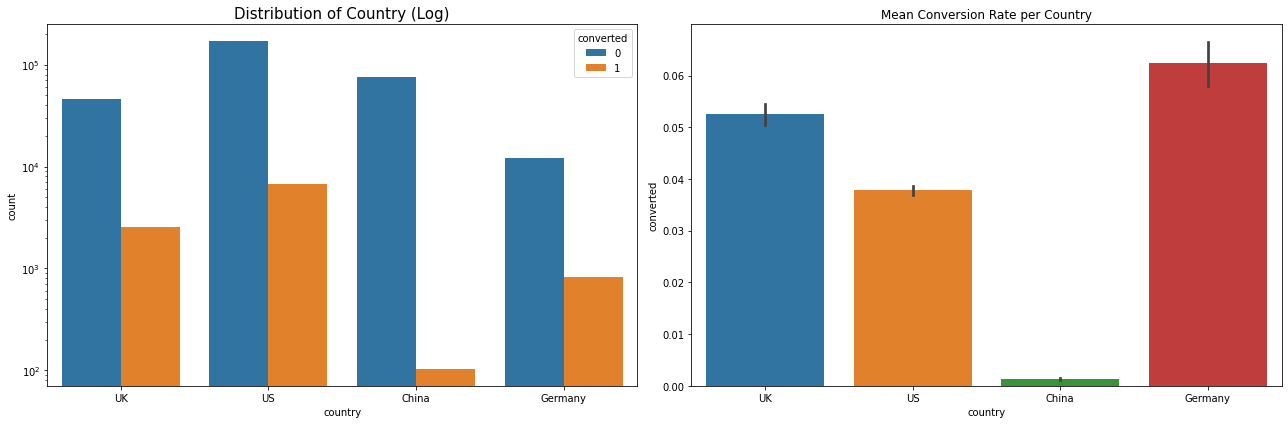

In [41]:
# visualization of different countries 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Distribution of Country (Log)', fontsize=15)
ax[0].set_yscale('log')

sns.barplot(x='country', y='converted', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Country')
plt.tight_layout()
plt.show();

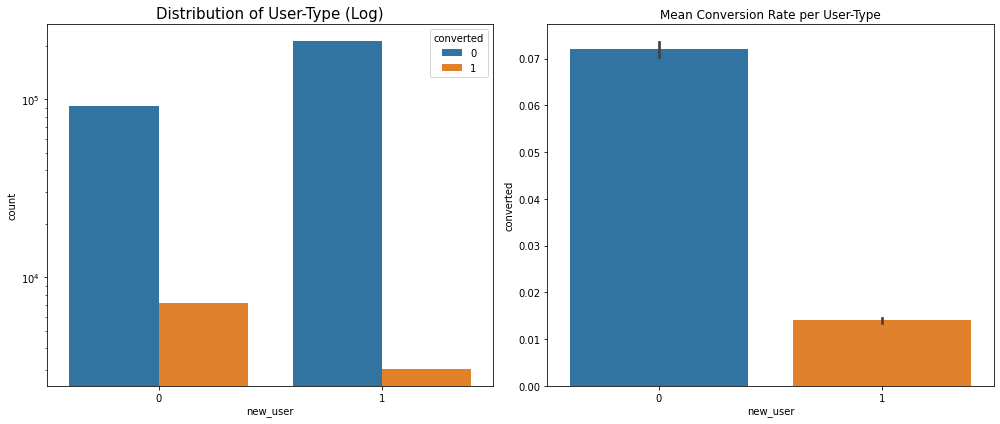

In [40]:
# Visualization of different user types
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Distribution of User-Type (Log)', fontsize=15)
ax[0].set_yscale('log')

sns.barplot(x='new_user', y='converted', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per User-Type')
plt.tight_layout()
plt.show();

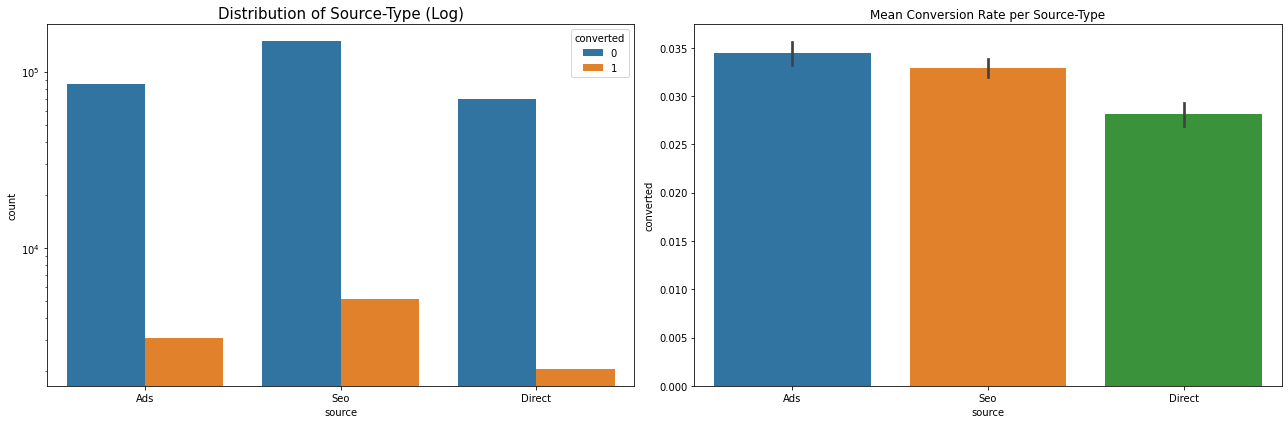

In [42]:
# Visualization of different sources
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Distribution of Source-Type (Log)', fontsize=15)
ax[0].set_yscale('log')

sns.barplot(x='source', y='converted', data=data, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Source-Type')
plt.tight_layout()
plt.show();

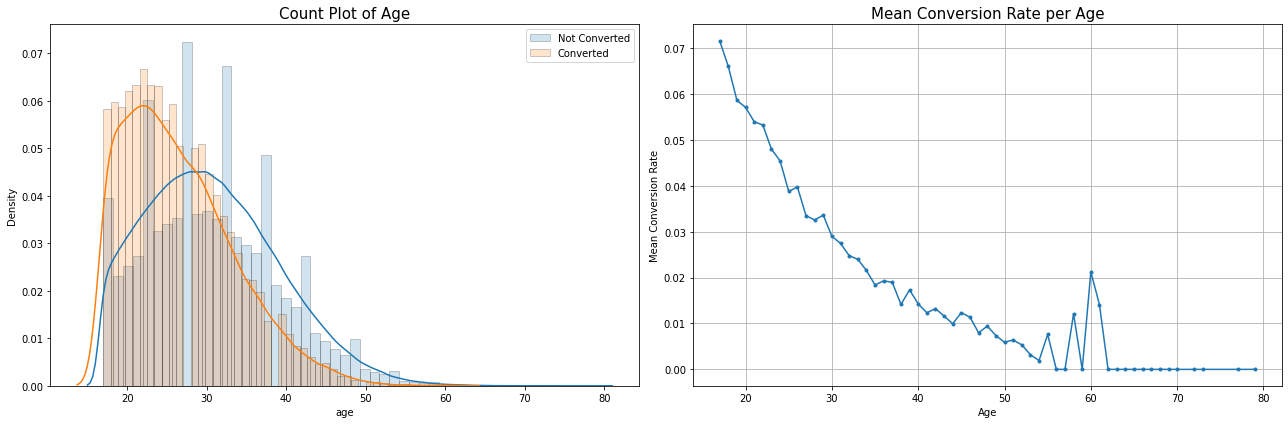

In [63]:
# Visualization of different age 
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted']==0]['age'], label='Not Converted', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted']==1]['age'], label='Converted', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age',fontsize=15)
ax[0].legend()

ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate per Age', fontsize=15)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid(True)
plt.tight_layout()
plt.show();

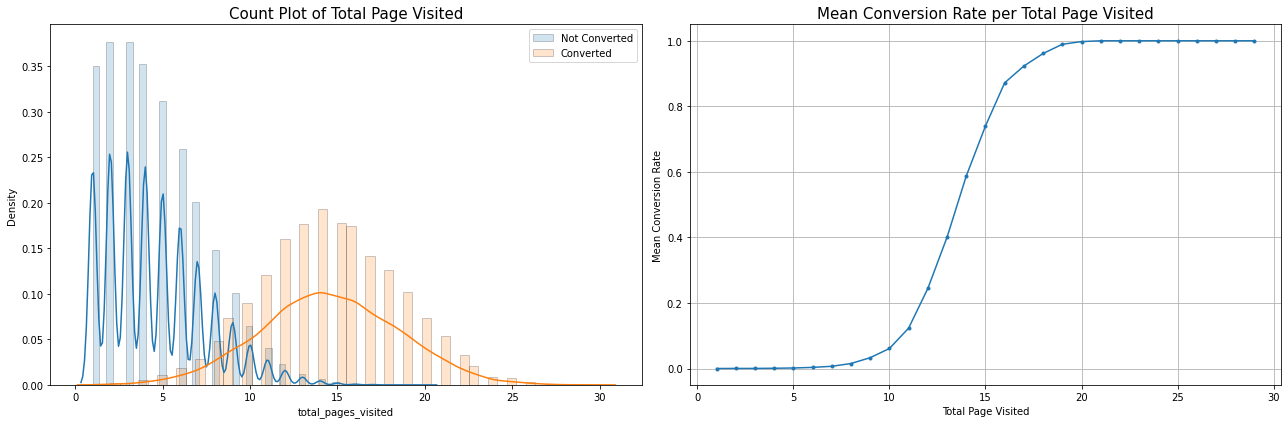

In [64]:
# Visualization of different page visits 
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted']==0]['total_pages_visited'], label='Not Converted', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted']==1]['total_pages_visited'], label='Converted', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Total Page Visited',fontsize=15)
ax[0].legend()

ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate per Total Page Visited', fontsize=15)
ax[1].set_xlabel('Total Page Visited')
ax[1].set_ylabel('Mean Conversion Rate')
ax[1].grid(True)
plt.tight_layout()
plt.show();

## Observations

- By Country: 
  1. The site have large Chinese-based users, but they have the lowest conversion rate. 
  2. On contrary, German is the smallest user group in this site, but they have the highest conversion rate.  

- By User-type:
  1. New users visit the site more, but only few of them buy things. 

- By Age group: 
  1. There's a age gap among converted users (late 20s to early 30s, late 30s to early 40s). 
  2. Users at early 20s, 30s, and 40s are more likely to buy things. 

- By total pages visited:
  1. The more pages users visited, the higher conversion rate the site has. 

# Build Model

In [ ]:
# Initialize H2O Cluster 
h2o.init()
h2o.remove_all()

In [70]:
# Transform to H2O Frame
h2o_df = H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [72]:
# make sure the categorical variables
h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


## Random Forest Model 

In [73]:
# Split into 70% training and 30% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.3, seed=20)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [75]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=20, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


## Features Importance 

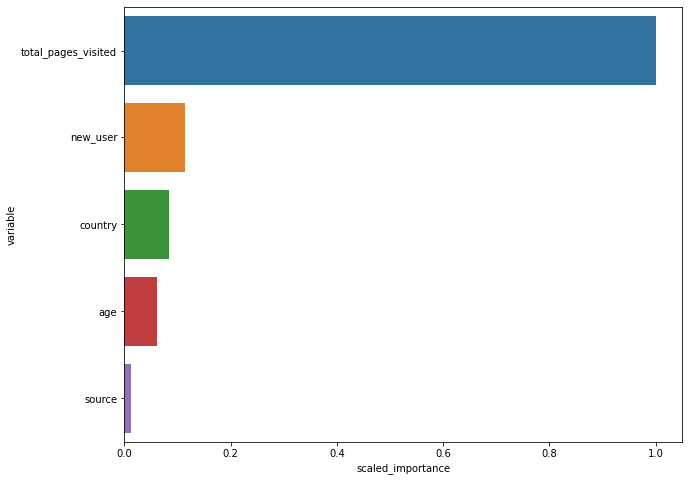

In [77]:
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

## Make Predictions 

In [80]:
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [81]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     91800
           1       0.85      0.64      0.73      3059

    accuracy                           0.98     94859
   macro avg       0.92      0.82      0.86     94859
weighted avg       0.98      0.98      0.98     94859



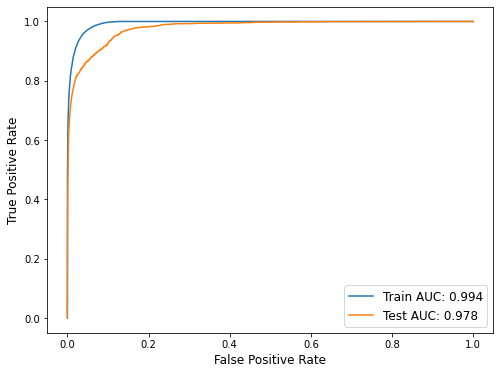

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


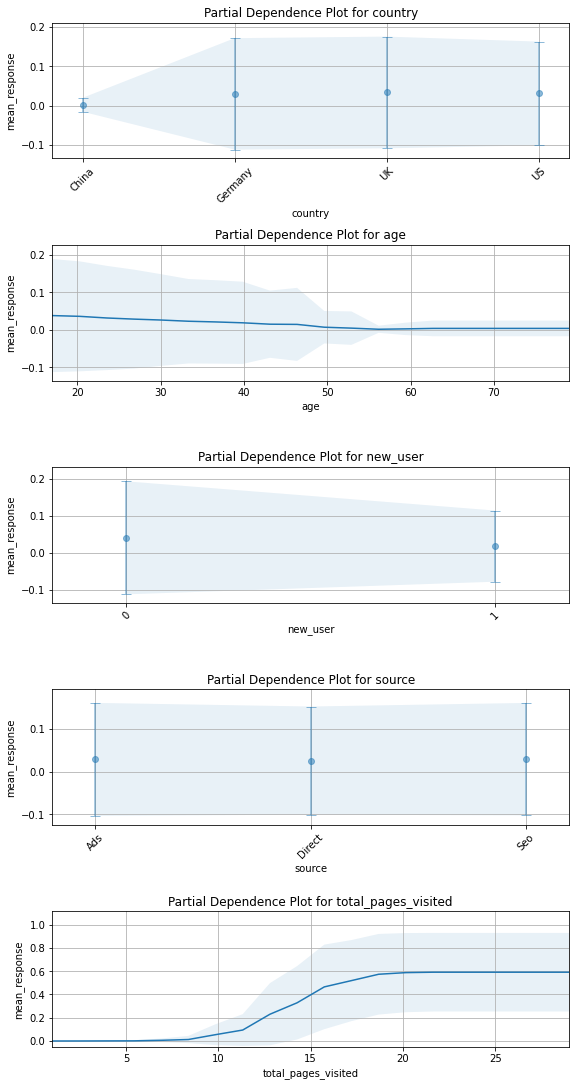

In [84]:
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

In [86]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_986c closed.


# Conclusion 

1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.

2. Maybe go through the UI and figure out why older users perform so poorly? From ~30 y/o conversion clearly starts dropping. A good actionable metric here is conversion rate for people >=30 yr old. Building a team whose goal is to increase that number would be interesting.

3. The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

4. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity.

4. Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.